# Barcode Scanner


## Project Setup


In [1]:
import contextlib
import os
from collections import deque
from typing import Any

import cv2 as cv
import matplotlib.pyplot as plt
from cv2.typing import MatLike
from numpy import array, intp, ones, signedinteger, uint8, unique, ones_like

In [2]:
transformation_images = []

## Barcode Extraction Pipeline

In [3]:
def preprocess_image(image: MatLike) -> MatLike:
    """Preprocess image to make it ready for contouring

    Args:
        image (MatLike): Original image without any filters applied on it

    Returns:
        MatLike: Preprocessed image
    """
    img = image.copy()
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    # Detect whether the image has colors
    lower_black = array([0, 0, 0])
    upper_black = array([180, 255, 50])
    # Define the range for gray colors in HSV
    lower_gray = array([0, 0, 50])
    upper_gray = array([180, 50, 200])
    # Define the range for white colors in HSV
    lower_white = array([0, 0, 200])
    upper_white = array([180, 50, 255])
    # Create masks for black, gray, and white colors
    black_mask = cv.inRange(img_hsv, lower_black, upper_black)
    gray_mask = cv.inRange(img_hsv, lower_gray, upper_gray)
    white_mask = cv.inRange(img_hsv, lower_white, upper_white)
    # Combine the masks
    combined_mask = cv.bitwise_or(black_mask, gray_mask)
    combined_mask = cv.bitwise_or(combined_mask, white_mask)
    # Invert the mask to get non-gray colors
    non_gray_mask = cv.bitwise_not(combined_mask)
    # Check if there are any non-gray pixels
    if non_gray_mask.any():
        print("image contains colors")
        kernel = ones((5, 5), uint8)
        non_gray_mask = cv.morphologyEx(
            non_gray_mask, cv.MORPH_CLOSE, kernel
        )  # Close any holes in the mask foreground
        non_gray_mask = cv.morphologyEx(
            non_gray_mask, cv.MORPH_OPEN, kernel
        )  # Remove any colorful noises in the mask background
        inpainted_image = cv.bitwise_and(img_gray, gray_mask) # Apply the mask
        transformation_images.append((inpainted_image, "Inpaint"))
        _, img_gray = cv.threshold(img_gray, 50, 255, cv.THRESH_BINARY)
        transformation_images.append((img_gray, "Binary Threshhold"))

    img_blurred = cv.medianBlur(
        cv.blur(img_gray, (3, 3)), 3
    )  # Blur image to reduce salt and pepper noise
    transformation_images.append((img_blurred, "Median Blur"))
    _, img_denoised = cv.threshold(
        img_blurred, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
    )  # OTSU threshhold to remove contrast, low/high brightness and noise problems
    transformation_images.append((img_denoised, "OTSU Threshhold"))

    # Test whether the image contains sin wave noise
    kernel = cv.getStructuringElement(
        cv.MORPH_RECT, (50, 1)
    )  # Horizontal kernel to remove all bars
    img_dilated = cv.morphologyEx(img_denoised, cv.MORPH_DILATE, kernel)  # Remove bars
    # Sin waves are wider than the bars, so they will not be remove by the prev dilation
    if (
        len(unique(img_dilated)) > 1
    ):  # Check if there is more the one color. If so then dilation operation did not clear the image, thus sin waves.
        print("image contains sin wave noise")
        transformation_images.append((img_gray, "Revert back to inpainted/original image"))
        img_denoised = cv.adaptiveThreshold(
            img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2
        )  # Remove sin waves using adaptive threshhold, as the sin wave looks like lighting problem.
        transformation_images.append((img_denoised, "Adaptive Threshold"))

    return img_denoised

In [4]:
def find_barcode_contours(image: MatLike) -> tuple[signedinteger[Any], int, int] | None:
    """Attempt to find the contours of a barcode within the image.

    Args:
        image (MatLike): _description_

    Returns:
        tuple[signedinteger[Any], int, int] | None: _description_
    """
    img = image.copy()

    # Preprocess image for contour detection
    img_edges = cv.Canny(img, 100, 200)  # Detect edges
    transformation_images.append((img_edges, "Canny"))
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (16, 1))
    img_closed = cv.morphologyEx(
        img_edges, cv.MORPH_CLOSE, kernel
    )  # close the edges to obtain a mask for the barcode
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (9, 9))
    img_closed = cv.morphologyEx(
        img_closed, cv.MORPH_OPEN, kernel
    )
    transformation_images.append((img_closed, "Closing"))
    _, img_closed_binary = cv.threshold(
        img_closed, 50, 255, cv.THRESH_BINARY
    )  # binarize the image
    transformation_images.append((img_closed_binary, "Binary Threshold"))

    contours, _ = cv.findContours(
        img_closed_binary, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE
    )
    if len(contours):
        largest_contour = max(
            contours, key=cv.contourArea
        )  # Get the largest contour assuming, after preprocessing, that it is the barcode
        rect = cv.minAreaRect(
            largest_contour
        )  # Get the minimum area rotated bounding rectangle
        box = cv.boxPoints(rect)  # Get the four rectangles four points
        box = intp(box)  # Convert all coordinates to integers

        # Draw the bounding box on the original image for debugging
        img_colored = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        img_colored = cv.drawContours(img_colored, [box], 0, (0, 255, 0), 2)
        transformation_images.append((img_colored, "Contouring"))
        # plt.imshow(img_colored)

        # Get the width and height of the bounding box
        width = int(rect[1][0])
        height = int(rect[1][1])

        return box, width, height
    print("No contours were found")
    return None, None, None

In [5]:
def vertical_erosion_dilation(image: MatLike) -> MatLike:
    """
    Perform vertical erosion and then vertical dilation on an input image.

    Args:
        image (MatLike): The input image (Mat-like object) as a NumPy array.

    Returns:
        MatLike: The image after vertical erosion and dilation.
    """
    cleaned_barcode = image.copy()

    # All our kernel are vertical since we want to fill black/white vertical bars
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 16))
    cleaned_barcode = cv.morphologyEx(
        cleaned_barcode, cv.MORPH_CLOSE, kernel, iterations=1
    )  # Remove any black dots as aggressive erosion will be applied first
    transformation_images.append((cleaned_barcode, "Closing"))
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, 256))
    cleaned_barcode = cv.morphologyEx(
        cleaned_barcode, cv.MORPH_ERODE, kernel, iterations=1
    )
    transformation_images.append((cleaned_barcode, "Erosion"))
    cleaned_barcode = cv.morphologyEx(
        cleaned_barcode, cv.MORPH_DILATE, kernel, iterations=5
    )
    transformation_images.append((cleaned_barcode, "Dilation"))

    return cleaned_barcode

In [6]:
def extract_barcode(image: MatLike) -> MatLike | None:
    """Extract barcode from an image

    Args:
        image (MatLike): Original image

    Returns:
        MatLike | None: Barcode image if found. Otherwise returns None
    """

    transformation_images.append((image, "Original Image"))

    cleaned_img = preprocess_image(image)  # Preprocess the image

    bounding_box, width, height = find_barcode_contours(
        cleaned_img
    )  # Find barcode boundaries

    if bounding_box is not None:
        destination_points = array(
            [[0, height - 1], [0, 0], [width - 1, 0], [width - 1, height - 1]],
            dtype="float32",
        )  # Destination points is a centered rectangle (not warped by any means)
        M = cv.getPerspectiveTransform(
            bounding_box.astype("float32"), destination_points
        )  # Get the perspective transform matrix
        warped = cv.warpPerspective(cleaned_img, M, (width, height))
        # Perspective transform may transform the image into portrait orientation instead of landscape
        if (
            warped.shape[0] > warped.shape[1]
        ):  # Check if height is bigger than width (portrait orientation)
            warped = cv.rotate(warped, cv.ROTATE_90_CLOCKWISE)
        _, warped_binary = cv.threshold(
            warped, 50, 255, cv.THRESH_BINARY + cv.THRESH_OTSU
        )  # Binarize the image to collect optimum results from the decoder
        transformation_images.append((warped_binary, "Perspective Warping"))
        warped_cleaned = vertical_erosion_dilation(
            warped_binary
        )  # Restore the barcode after many linear and non-linear operations

        return warped_cleaned

    print("No contour was found")
    return None


## Visualize Barcode Extraction Results

In [7]:
def plot_image(
    file_name: str, original_image: MatLike, barcode_image: MatLike | None = None
) -> None:
    """Plot the original image and the barcode extrracted from it

    Args:
        file_name (str): Name of the image file
        original_image (MatLike): Original image without any preprocessing
        barcode_image (MatLike | None, optional): Extracted barcode image if found. Defaults to None.
    """
    plt.figure(figsize=(15, 20))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.title(f"Processed {file_name}")
    plt.axis("off")
    plt.imshow(original_image, cmap="gray")

    # Plot the extracted barcode from the original image
    plt.subplot(1, 2, 2)
    plt.title(f"{file_name} Extracted Barcode")
    plt.axis("off")
    if barcode_image is not None:
        plt.imshow(barcode_image, cmap="gray")
    else:
        print(f"No barcode detected for {file_name}.")

    # plt.show()

## Barcode Decoding

In [8]:
def decode_barcode(image: MatLike) -> None:
    """Decode barcode image using code 11 algorithm

    Args:
        image (MatLike): Barcode image to be decoded
    """
    # 0 means narrow, 1 means wide
    NARROW = "0"
    WIDE = "1"
    code11_widths = {
        "00110": "Stop/Start",
        "10001": "1",
        "01001": "2",
        "11000": "3",
        "00101": "4",
        "10100": "5",
        "01100": "6",
        "00011": "7",
        "10010": "8",
        "10000": "9",
        "00001": "0",
        "00100": "-",
    }

    img = image.copy()

    # Get the average of each column in your image
    mean = img.mean(axis=0)

    # Set it to black or white based on its value
    THRESHOLD = 127
    mean[mean <= THRESHOLD] = 1
    mean[mean > THRESHOLD] = 0

    # Convert to string of pixels in order to loop over it
    pixels = "".join(mean.astype(uint8).astype(str))

    # Need to figure out how many pixels represent a narrow black and white bar
    pixel_index = 0
    # Measure first narrow black bar width
    black_narrow_bar_size = 0
    while True:
        try:  # Corrupted images may lead to passing image boundaries without finding a black bar between white bars
            pixel = pixels[pixel_index]
        except IndexError:
            print("The barcode is corrupted. Find below possible reasons:")
            if not black_narrow_bar_size:
                print("The barcode is a white image")
            else:
                print("The first black bar spans horizontally to the end of the image")

        if pixel == "1":  # Current pixel is black pixel
            black_narrow_bar_size += 1
        elif (
            black_narrow_bar_size
        ):  # Current pixel is white && we measured our first black narrow bar width
            break  # Break at the first white pixel just after the black bar
        pixel_index += 1

    # Measure first narrow white bar width
    white_narrow_bar_size = 0
    try:  # Corrupted images may lead to passing image right boundary without finding a white bar between black bars
        while (
            pixels[pixel_index] == "0"
        ):  # This while loop will start where we left off in the prev loop (at the first white pixel after the first black bar)
            white_narrow_bar_size += 1
            pixel_index += 1
    except IndexError:
        print(
            "The barcode is corrupted. The first white bar spans horizontally to the end of the image"
        )

    digits = []
    pixel_index = 0
    bars_buffer = deque(maxlen=5)
    bar_widths = ""  # For debugging
    is_black = False
    is_skip = False
    TOLERANCE = 1

    # Find the first black pixel
    while pixels[pixel_index] == "0":
        pixel_index += 1

    while pixel_index < len(pixels):
        is_black = not is_black  # Each iteration alternately measures the width of black and white bars in the barcode, starting with a black bar.

        bar_width = 1
        with contextlib.suppress(
            Exception
        ):  # This algorithm will raise an error at the last bar in the image
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                bar_width += 1
                pixel_index += 1
        pixel_index += 1

        if is_skip:  # if true, then this bar is a spacer
            is_skip = False
            bar_widths += "-"
            continue

        # Based on the width of the first black/white bar, categorize the current bar as 1(wide)/0(narrow)
        if is_black:
            bar_width_encoding = (
                NARROW if bar_width <= black_narrow_bar_size + TOLERANCE else WIDE
            )
        else:
            bar_width_encoding = (
                NARROW if bar_width <= white_narrow_bar_size + TOLERANCE else WIDE
            )
        bar_widths += bar_width_encoding
        bars_buffer.append(
            bar_width_encoding
        )  # Enque the bar width encoding (1/0) into the buffer

        if (
            len(bars_buffer) == 5
        ):  # Check if we have read a digit (each digit is encoded by 5 bars)
            buffer_str = "".join(bars_buffer)
            if buffer_str in code11_widths:
                digit = code11_widths[buffer_str]  # Decode the bars
                digits.append(digit)
            else:
                digits.append("*")  # "*" indicates that this code is unrecognizable
            bars_buffer.clear()
            is_skip = True  # Skip next spacer, since between each digit there is a white narrow bar (spacer)

    print(digits)
    plt.text(0, img.shape[0] + 16, bar_widths, fontsize=8)  # For debugging
    plt.show()

## Visualize the process in a GIF

In [9]:
from PIL import Image, ImageDraw, ImageFont
import imageio

def add_title(image, title, font_path='arial.ttf', font_size=20):
    image = Image.fromarray(image)
    # Create a new image with extra space for the title
    new_image = Image.new("L", (image.width, image.height + 50), color=255)
    new_image.paste(image, (0, 50))
    
    draw = ImageDraw.Draw(new_image)
    font = ImageFont.truetype(font_path, font_size)
    text_bbox = draw.textbbox((0, 0), title, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    position = ((new_image.width - text_width) // 2, 10)
    draw.text(position, title, (0), font=font)
    
    return new_image

def create_transformations_gif(file_name: str, common_size: tuple):
    STEPS = 10
    resized_transformation_images = [add_title(cv.resize(img[0], common_size), img[1]) for img in transformation_images]
    gif_images = []
    for i in range(len(resized_transformation_images) - 1):
        img1 = resized_transformation_images[i]
        for _ in range(STEPS):
            gif_images.append(img1)
        img2 = resized_transformation_images[i+1]
        for i in range(STEPS):
            alpha = i / float(STEPS)
            img = Image.blend(img1.convert("RGBA"), img2.convert("RGBA"), alpha)
            gif_images.append(img.convert("L"))
    for _ in range(STEPS * 2):
        gif_images.append(img2)

    imageio.mimsave(f'gif/{file_name}.gif', gif_images, duration=0.1)
    transformation_images.clear()

## Apply our pipeline to images

In [10]:
def extract_barcodes(
    images_dir: str, output_dir: str = r".\processed_barcodes"
) -> None:
    """Extract a barcode from each image in the images directory and saves the result as an image in output directory

    Args:
        images_dir (str): Path to the directory that contains the images to extract barcodes from
        output_dir (str, optional): Path to the directory to save the images of barcodes in. Defaults to r".\processed_barcodes".
    """

    IMAGE_FILES_EXTENSIONS = {
        ".png",
        ".jpg",
        ".jpeg",
        ".bmp",
        ".tiff",
        ".tif",
    }  # List of valid image extensions for OpenCV

    for file_name in os.listdir(images_dir):  # Iterate over files in the directory
        ext = os.path.splitext(file_name)[1].lower()  # Get the file extension
        if ext in IMAGE_FILES_EXTENSIONS:  # Check if the file is an image
            print(f"Processing: {file_name}")
            image_path = os.path.join(images_dir, file_name)
            image = cv.imread(image_path)
            barcode = extract_barcode(image)  # Extract barcode
            plot_image(
                file_name, image, barcode
            )  # Plot original image and extracted barcode
            decode_barcode(barcode)
            common_size = transformation_images[1][0].shape[::-1]
            create_transformations_gif(file_name, common_size)
        else:
            print(f"{file_name} is not an image file.")

Processing: 01 - lol easy.jpg
['Stop/Start', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'Stop/Start']


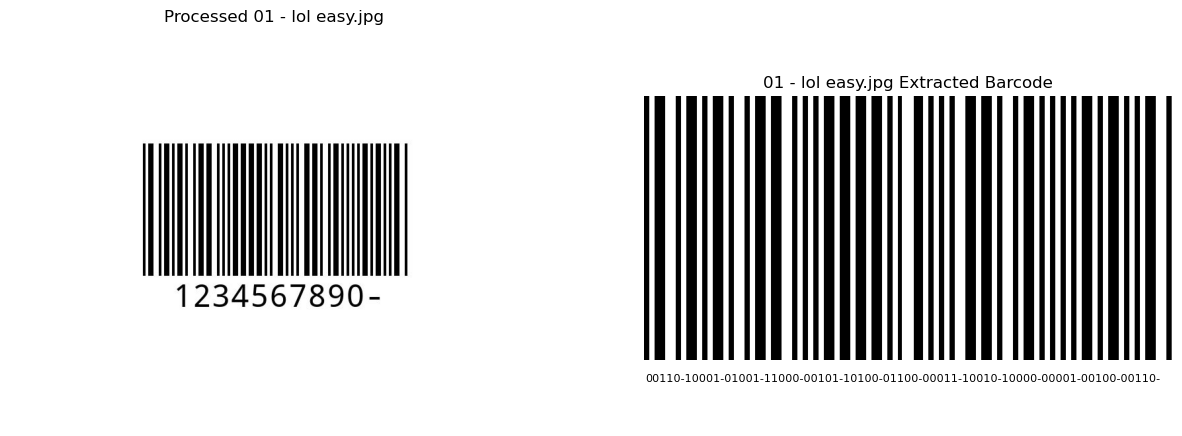

Processing: 02 - still easy.jpg
['Stop/Start', '1', '0', '4', '-', '1', '1', '6', '-', '1', '1', '6', 'Stop/Start']


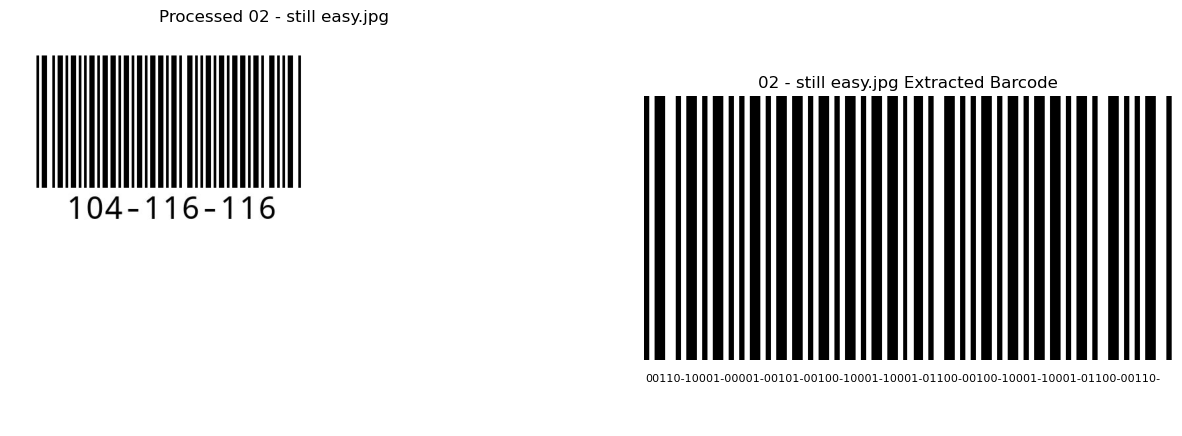

Processing: 03 - eda ya3am ew3a soba3ak mathazarsh.jpg
image contains colors
['Stop/Start', '1', '1', '2', '-', '1', '1', '5', '-', '5', '8', '-', 'Stop/Start']


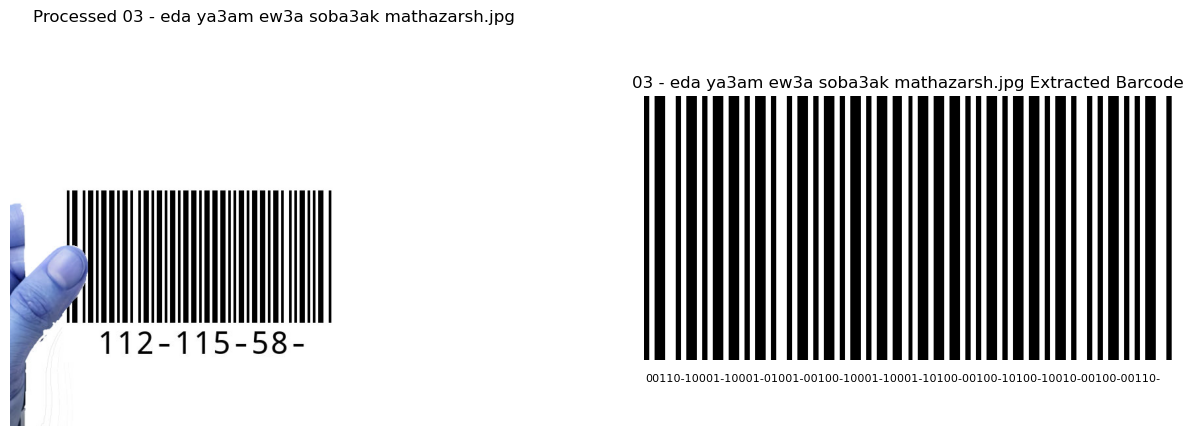

Processing: 04 - fen el nadara.jpg
['Stop/Start', '-', '4', '7', '-', '4', '7', '-', '1', '2', '1', '-', 'Stop/Start']


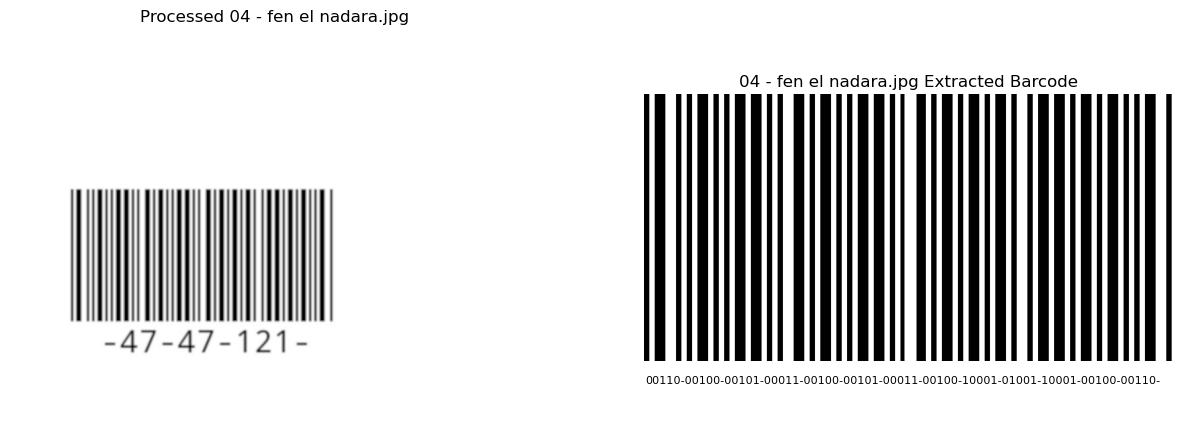

Processing: 05 - meen taffa el nour!!!.jpg
['Stop/Start', '1', '1', '1', '-', '1', '1', '7', '-', '1', '1', '6', 'Stop/Start']


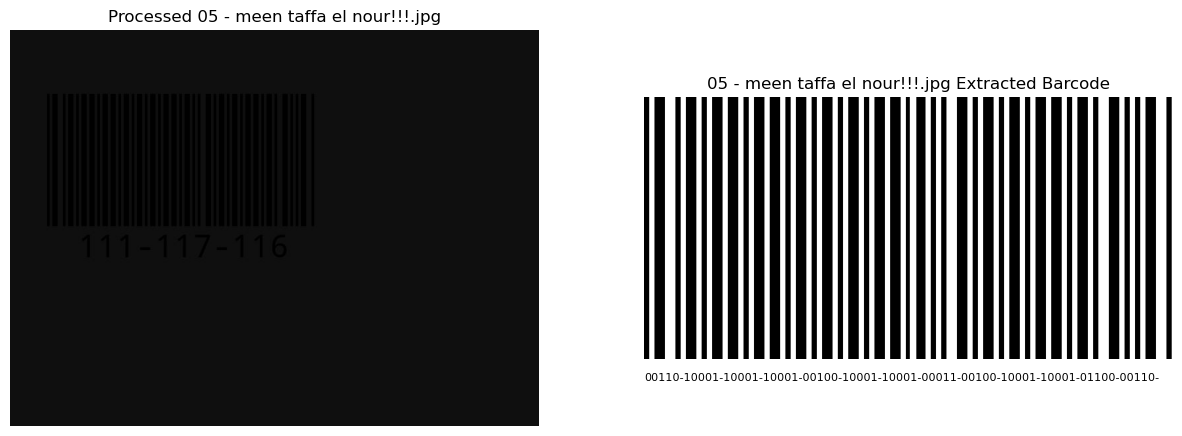

Processing: 06 - meen fata7 el nour 333eenaaayy.jpg
['Stop/Start', '-', '1', '1', '7', '-', '4', '6', '-', '9', '8', '-', 'Stop/Start']


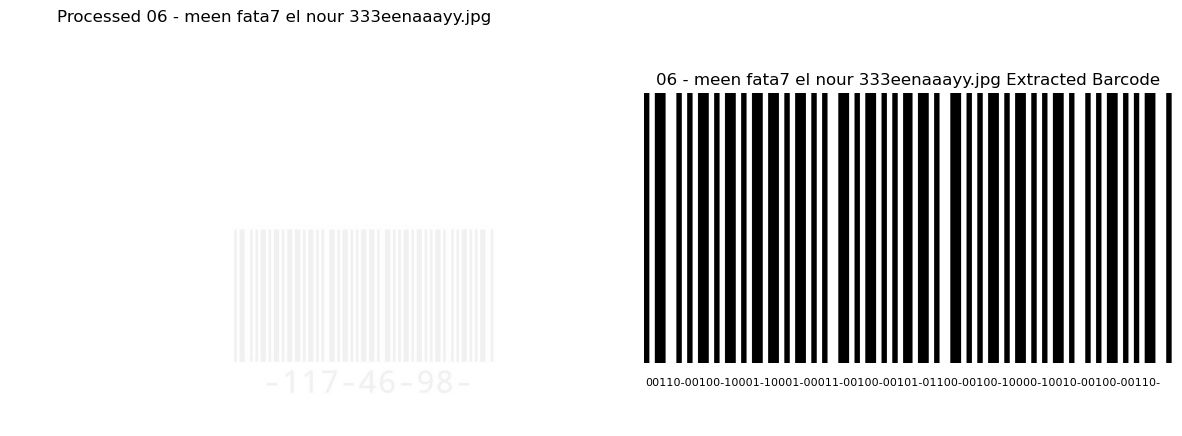

Processing: 07 - mal7 w felfel.jpg
['Stop/Start', '1', '0', '1', '-', '4', '7', '-', '1', '0', '0', '-', 'Stop/Start']


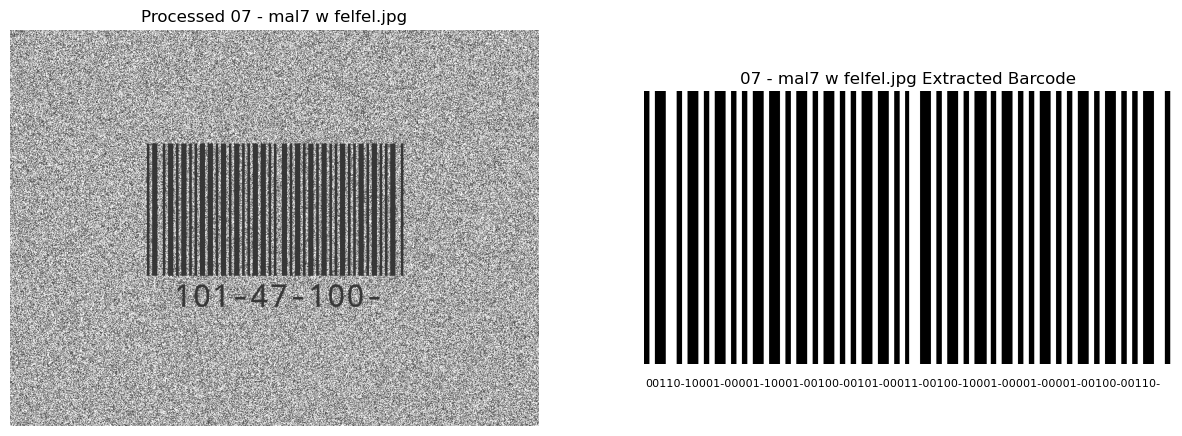

Processing: 08 - compresso espresso.jpg
['Stop/Start', '1', '1', '3', '-', '1', '1', '9', '-', '5', '2', '-', 'Stop/Start']


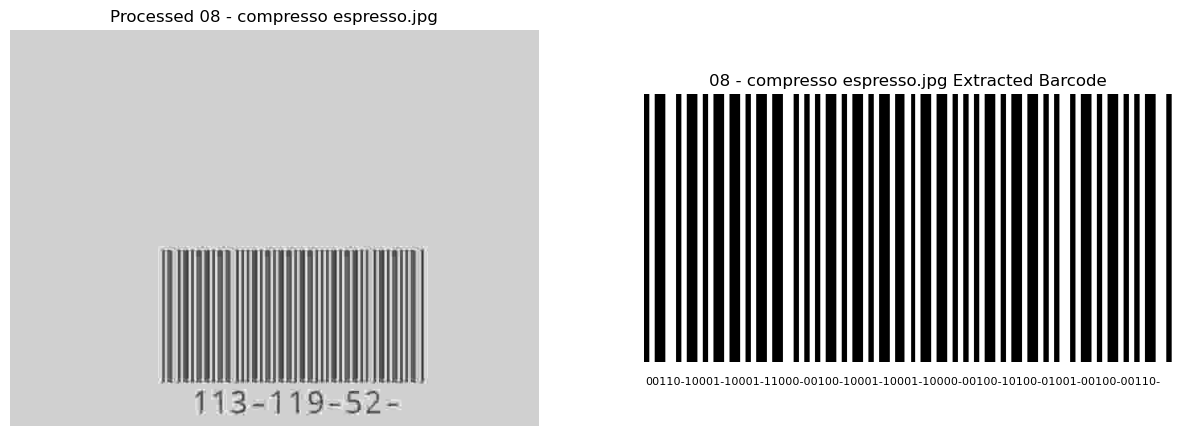

Processing: 09 - e3del el soora ya3ammm.jpg
['Stop/Start', '1', '1', '9', '-', '5', '7', '-', '1', '1', '9', '-', 'Stop/Start']


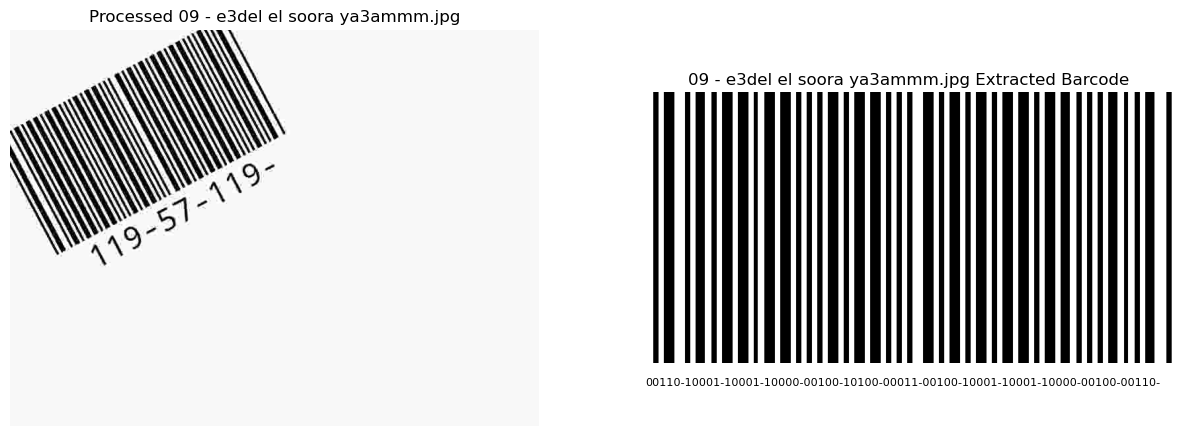

Processing: 10 - wen el kontraastttt.jpg
['Stop/Start', '1', '0', '3', '-', '1', '2', '0', '-', '9', '9', '-', 'Stop/Start']


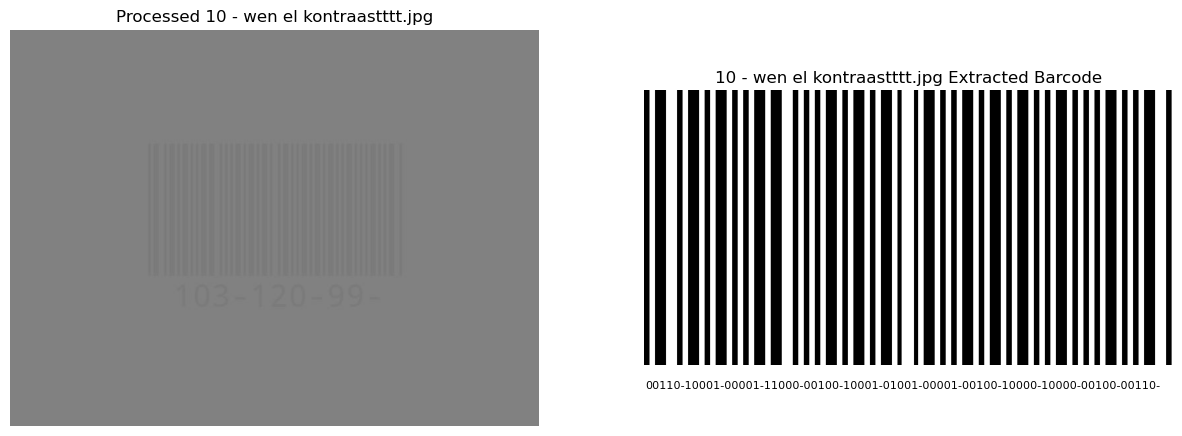

Processing: 11 - bayza 5ales di bsara7a.jpg
image contains sin wave noise
['Stop/Start', '1', '1', '3', '-', '4', '7', '-', '3', '5', '-', '3', '5', 'Stop/Start']


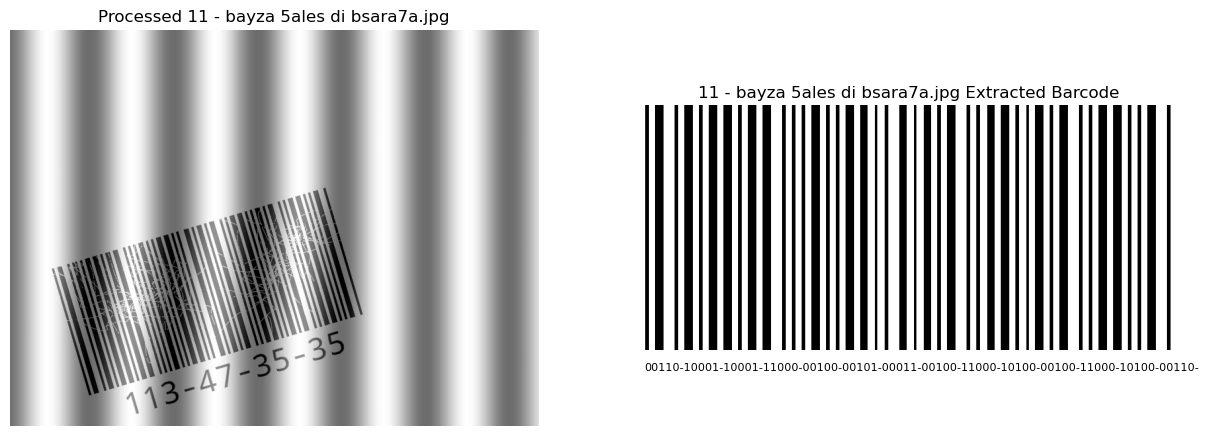

processed_barcodes is not an image file.


In [11]:
# Define the folder containing the test images
IMAGES_DIR = r".\test_cases"

# Specify the output folder where you want to save the extracted barcodes
OUTPUT_DIR = os.path.join(IMAGES_DIR, "processed_barcodes")

# Ensure the output folder exists
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Process all test images
extract_barcodes(IMAGES_DIR, OUTPUT_DIR)